In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn



### Parameterize Gaussian 

softplus function을 사용한다. 왜? 현재 encoding layer의 output은 어떤 데이터 값이 아니라, 그 데이터를 generate할 수 있는 분포의 parameter이다. 따라서, input을 현재 2차원 공간으로 투영시킬 것이기 때문에 2차원 gaussian모형에 필요한 모수가 encoding layer의 결과물이어야 한다. 

그런데 문제는 !! encoding layer의 output은 어떤 숫자든 될 수 있다. feed forward nn과 같은 것이기 때문에 당연히 아무 숫자나 될 수 있다. 따라서 항상 양수가 되게끔 해주려고, 이 x를 softplus function에 통과시켜서 양수화 시켜준다.(softplus는 relu같은함수로써, 정의역은 실수전체이나, 치역은 0이상인 수이므로) 

In [2]:

def softplus(x):
    
    ## log1p(x) == log(1+x) : 로그함수의 input에다가 알아서 1을 더해준다. 이유는 그러는 것이 더 안정적이라서 
    
    return np.log1p(np.exp(x))
    

현재 모델링하고 있는 network의 구조는 1 개의 hidden layer를 갖고 있다. 
layer를 이루고 있는 node의 갯수는 (4,3,2) 
즉, input_layer = 4 , hidden_layer = 3, latent variable 갯수: 2 이므로, 
encoding layer의 size 는 (4,3,2) 가 된다. 
### 즉 2차원의 latent한 space에 응축시키겠다는 말임. 

이에 따라, first weight의 size 는 4*3 이고, second weight의 size 는 3*4이다. (hidden -> latent variable로 가려면 3*2 가 되어야할 것 같은데, 왜 3*4가 되는것이지?? ) 

아 근데, latent variable의 갯수가 2개. 즉 gaussian 분포가 2개라는 것이다. gaussian 분포가 두개이려면, $\mu , \sigma$ 가 각각 2개씩 있어야하므로, 결국에는 4개의 parameter를 유추해야 한다. 



In [13]:
# 가중치를 임의로 뽑기. 이 때, 가중치의 size에 유의할 것. 
w1 = np.random.randn(4,3)
w2 = np.random.randn(3, 2*2)

def forward(x, w1, w2):
    hidden = np.tanh(x.dot(w1))
    output = hidden.dot(w2)
    
    # 즉 encoding layer의 4개의 output 중에서 앞에 2개는 mean을 말하는 것이고, 
    # 뒤에 2개는 stddev를 말하는 것이다. 
    mean = output[:2]
    stddev = softplus(output[2:])
    return mean, stddev

In [3]:
w1 = np.random.randn(4,3)
w2 = np.random.randn(3, 2*2)
w1
w2

array([[-0.82685218, -0.03877091,  1.56833207,  1.42733647],
       [-0.33452689,  0.55535944, -0.41259639, -2.08732253],
       [-0.17966116,  0.44209052,  0.65966693,  2.16459904]])

In [14]:
x = np.random.randn(4)
x

array([-0.61293097,  1.31108008, -1.61364037, -0.01914904])

In [15]:
## 주어진 random한 숫자인 x에서 4개의 숫자를 뽑은 다음에, 그 숫자들에 대한 mean, stddev를 구한다. 

mean, stddev = forward(x, w1, w2)
print("mean: ", mean)
print("stddev: ", stddev)



mean:  [0.26425447 0.15822882]
stddev:  [2.29022864 1.72267377]


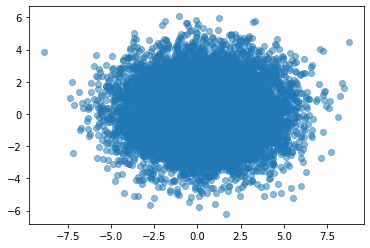

In [17]:
# 그리고, 우리가 유추해낸 parameter를 가진 모델로부터, (2개의 gaussian) sample을 추출해낸다. 
samples = mvn.rvs(mean=mean, cov = stddev**2, size=10000)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5)
plt.show()

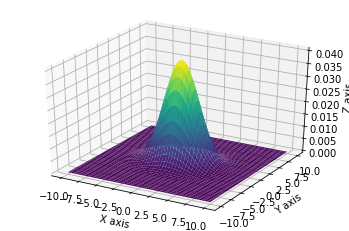

In [26]:
#Create grid and multivariate normal
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = mvn(mean, stddev**2)

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

어떤 input을 feed forward 해서 neural network에 통과시켰고, 그 결과 값이 아니라, 위와 같이 2차원 gaussian 분포가 나왓다. 이 분포에서 sample을 draw하는 것이다.

#### 그런데 ! value가 아닌, 분포가 결과물인데, 어떻게 값을 갱신해나가는 gradient descent를 시행할까? 

즉 input에 dependent한 q(z)가 만들어진다. (혹은 q(z|x) 라고 표현할 수 있다.) 
(위의 예에 비춰본다면, q(z) 는 2차원 gaussian 분포가 된다.) 
